# Problem Statement

For the new game player who don't know which subreddit they should post in. I will try to classify by the text input (from post) which subreddit should the post be the reddit and auto classify to that subreddit. For instance, player on reddit no longer need to look for game subreddit themself anymore just post and model will predict which game subreddit this post should be in!

This is the proof of concept of the project the classify subreddit game. Which will create model to classify League of Legends (LoL) and DotA2 by gathering posts from subreddit /r/leagueoflegends and /r/DotA2.

I will focus on the model accuracy which predict the subreddit from title and posts. Also try to generalize to use with other more games.

## Import all necessary library

In [129]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#remove warning
import warnings
warnings.filterwarnings('ignore')

#to remove unscape
from xml.sax.saxutils import unescape

#import to draw wordcloud
from wordcloud import WordCloud, STOPWORDS

# import nltk and re to do word cleaning
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# import model sklearn:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer#, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,roc_auc_score 
from sklearn.neighbors import KNeighborsClassifier

#download stopword & wordnet
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

-----------------------------------

## Get post from reddit web (/r/DotA2.json and /r/leagueoflegends)

specific url on reddit and header to request data from reddit API

In [2]:
url1 = 'https://www.reddit.com/r/leagueoflegends.json'
url2 = 'https://www.reddit.com/r/DotA2.json'
headers = {'User-agent':'Bllep blorp bot 0.1'}

In [3]:
res1 = requests.get(url1,headers=headers)
res2 = requests.get(url2,headers=headers)

Check status code from reddit - Success to call API or not

In [4]:
print(res1.status_code)
print(res2.status_code)

200
200


Get post and turn it into json format

In [5]:
league_json = res1.json()
dota_json = res2.json()

**Create function to get up to 1,000 post to do a model**
- get unique ID of post / title of post / selftext of post
- using after parameter to continue to next page of reddit to get next post
- iterate 40 rounds to get 1,000 post (each page get only 25 posts)
    - doing a sleep to make sure that I will not spam on reddit server too much

In [6]:
def get_posts(url):
    posts = []
    after = None
    for i in range (40):
        print("We get a post from page number:",i+1)
        if after == None: #First time read URL - no params
            params = {}
        else:
            params = {'after':after}

        #url = 'https://www.reddit.com/r/leagueoflegends.json'
        res = requests.get(url, params = params, headers=headers)
        if res.status_code == 200:
            new_league_json = res.json()
            posts.extend(new_league_json['data']['children']) #append list of children to the post work like append append list of list
            after = new_league_json['data']['after']
        else:
            print(res.status_code,"Error")
            break

        #slow down the loop to make sure will not hit server too hard 
        ## Must do try another time do make not dup
        time.sleep(1)
    return posts

Call function and get the post

In [7]:
league_posts = get_posts(url1)
dota2_posts = get_posts(url2)

We get a post from page number: 0
We get a post from page number: 1
We get a post from page number: 2
We get a post from page number: 3
We get a post from page number: 4
We get a post from page number: 5
We get a post from page number: 6
We get a post from page number: 7
We get a post from page number: 8
We get a post from page number: 9
We get a post from page number: 10
We get a post from page number: 11
We get a post from page number: 12
We get a post from page number: 13
We get a post from page number: 14
We get a post from page number: 15
We get a post from page number: 16
We get a post from page number: 17
We get a post from page number: 18
We get a post from page number: 19
We get a post from page number: 20
We get a post from page number: 21
We get a post from page number: 22
We get a post from page number: 23
We get a post from page number: 24
We get a post from page number: 25
We get a post from page number: 26
We get a post from page number: 27
We get a post from page number

Check out number of posts
- don't meet 1,000 post may be in subreddit not have enough post

In [8]:
#len(posts)
print(len(league_posts))
print(len(dota2_posts))

1003
983


Check the duplicate post

In [9]:
#to make sure it will not duplicate
print(len(set([p['data']['name'] for p in league_posts])))
print(len(set([p['data']['name'] for p in dota2_posts])))

701
932


**Create function to convert the post from json format into Dataframe**

In [10]:
def to_df(posts):
    names = []
    titles = []
    texts = []
    subreddits = []

    for i in range(len(posts)):
        names.append(posts[i]['data']['name'])
        titles.append(posts[i]['data']['title'])
        texts.append(posts[i]['data']['selftext'])
        subreddits.append(posts[i]['data']['subreddit'])

    df_posts = pd.DataFrame({'name': names, 'title': titles, 'text': texts, 'subreddit': subreddits})
    return df_posts

Make league of legend json and Dota2 into dataframe

In [11]:
df_league = to_df(league_posts)
df_league

name                                              title  \
0     t3_m7yb15           March 20th and 21st Clash LFG Megathread   
1     t3_m5m1an   r/LeagueofLegends is looking for new moderators!   
2     t3_m7t72z  Viego is the embodiment of what drives mages o...   
3     t3_m7pab8  Recently I've been playing off-meta botlanes s...   
4     t3_m7q7m9                            Evelynn Baddest cosplay   
...         ...                                                ...   
998   t3_m7yhww  I have just received my new Logitech K/DA gear...   
999   t3_m7tbvt                How to be a good support to Ezrael?   
1000  t3_m7tb21                          Finding a main (help pls)   
1001  t3_m7t7zx            E-Sorts in a higher age still possible?   
1002  t3_m7t6u2     Is the upcoming pass worth for a casual player   

                                                   text        subreddit  
0     Hello Everyone, Riot announced another Clash e...  leagueoflegends  
1     Hello Everyone,\n\nWe are looking to [recruit ...  leagueoflegends  
2     Viego perfectly encapsulates the current gamep...  leagueoflegends  
3                                                        leagueoflegends  
4     Guys, I know that the Hypetrain is already FAR...  leagueoflegends  
...                                                 ...              ...  
998   Brandishing my new G305 K/DA LIGHTSPEED WIRELE...  leagueoflegends  
999   Ok, first of all I would like to say that I'm ...  leagueoflegends  
1000  I have been playing a lot of league of lgends ...  leagueoflegends  
1001  Hey guys!\n\nDo you think it is still possible...  leagueoflegends  
1002  As far as I know, a new pass will arrive in th...  leagueoflegends  

[1003 rows x 4 columns]

In [12]:
df_dota2 = to_df(dota2_posts)
df_dota2

name                                              title  \
0    t3_m795ay  r/DotaAnime and Dragon's Blood release - rule ...   
1    t3_m7yvfm  New org to support female dota 2 players casua...   
2    t3_m82udx  Qsnake just received ban(and another one) on h...   
3    t3_m834c6            Hi :D this is a hungry baby tidehunter.   
4    t3_m7q69d  Probably my favorite Dota video: Pudge ganks m...   
..         ...                                                ...   
978  t3_m80txq  Just got free MMR against Void Spirit by level...   
979  t3_m7gu2s  If we're doing Dota Chess now... made one with...   
980  t3_m6xv42                               Every. Single. Time.   
981  t3_m7ln8s                              All According To Plan   
982  t3_m7ks48                              [OC](Male) naga siren   

                                                  text subreddit  
0    With the release date of Dragon's Blood fast a...     DotA2  
1                                                          DotA2  
2                                                          DotA2  
3                                                          DotA2  
4                                                          DotA2  
..                                                 ...       ...  
978                                                        DotA2  
979                                                        DotA2  
980                                                        DotA2  
981                                                        DotA2  
982                                                        DotA2  

[983 rows x 4 columns]

Remove post that are duplicate by checking it's name (which is the unique ID of the post)

In [13]:
df_league = df_league[df_league.duplicated(subset=['name'])==False]
df_league

name                                              title  \
0    t3_m7yb15           March 20th and 21st Clash LFG Megathread   
1    t3_m5m1an   r/LeagueofLegends is looking for new moderators!   
2    t3_m7t72z  Viego is the embodiment of what drives mages o...   
3    t3_m7pab8  Recently I've been playing off-meta botlanes s...   
4    t3_m7q7m9                            Evelynn Baddest cosplay   
..         ...                                                ...   
696  t3_m65p8x  Viego can possess Ornn and permanently upgrade...   
697  t3_m5ousp        Titanic be doing lotta damage... casual 1v4   
698  t3_m6n6go  Is there any way to re-play the Spirit Bonds v...   
699  t3_m5n57t  Can Autofill be balanced around Jungle right now?   
700  t3_m6wh8o                               KR M1 Yone Pentakill   

                                                  text        subreddit  
0    Hello Everyone, Riot announced another Clash e...  leagueoflegends  
1    Hello Everyone,\n\nWe are looking to [recruit ...  leagueoflegends  
2    Viego perfectly encapsulates the current gamep...  leagueoflegends  
3                                                       leagueoflegends  
4    Guys, I know that the Hypetrain is already FAR...  leagueoflegends  
..                                                 ...              ...  
696  Witnessed during a game the other day. Viego p...  leagueoflegends  
697                                                     leagueoflegends  
698  I really enjoyed playing the event's visual no...  leagueoflegends  
699  It would be incredibly nice if teams could be ...  leagueoflegends  
700                                                     leagueoflegends  

[701 rows x 4 columns]

In [14]:
df_dota2 = df_dota2[df_dota2.duplicated(subset=['name'])==False]
df_dota2

name                                              title  \
0    t3_m795ay  r/DotaAnime and Dragon's Blood release - rule ...   
1    t3_m7yvfm  New org to support female dota 2 players casua...   
2    t3_m82udx  Qsnake just received ban(and another one) on h...   
3    t3_m834c6            Hi :D this is a hungry baby tidehunter.   
4    t3_m7q69d  Probably my favorite Dota video: Pudge ganks m...   
..         ...                                                ...   
927  t3_m36nfs  The World of DOTA (feat. SirActionSlacks &amp;...   
928  t3_m4fjst  This is why you should always ward before roshing   
929  t3_m4as1f          console: failed to submit player feedback   
930  t3_m3myi9  Dota 2 Theory: Artifact's Rix is Fenrir (Dog-B...   
931  t3_m4f8fd  Anyone know around what time we usually get pa...   

                                                  text subreddit  
0    With the release date of Dragon's Blood fast a...     DotA2  
1                                                          DotA2  
2                                                          DotA2  
3                                                          DotA2  
4                                                          DotA2  
..                                                 ...       ...  
927                                                        DotA2  
928                                                        DotA2  
929  i got this message last match when i tried to ...     DotA2  
930  Artifact is dead, and as polarizing as it was ...     DotA2  
931  If I recall correctly its 2 times a year\n\nJu...     DotA2  

[932 rows x 4 columns]

Export file into .csv

In [15]:
df_dota2.to_csv("18March_dota2_post.csv",index=False)
df_league.to_csv("18March_league_post.csv",index=False)

-----

# EDA

Download post which we do before

In [16]:
df_dota2 = pd.read_csv('14March_dota2_post.csv')
df_league = pd.read_csv('14March_league_post.csv')

Check if any post that not have title and post text at the same time
- There is no empty title & post text at the same time
- Actually there is no null title post!

In [17]:
#There is no title and text that missing the both
df_dota2[df_dota2['text'].isnull()&df_dota2['title'].isnull()]

Empty DataFrame
Columns: [name, title, text, subreddit]
Index: []

In [18]:
#There is no title and text that missing the both
df_league[df_league['text'].isnull()&df_league['title'].isnull()]

Empty DataFrame
Columns: [name, title, text, subreddit]
Index: []

**So, I fill text which is nan value with '' to make it blank.<br>
And then concatenate title and text into new column name all_text** 
- I didn't drop the text which is null because in my opinion it's uniquely enough to classify from title only because LoL and DotA2 is have lots of unique name

In [19]:
#Fill nan value with blank, and I will concate with title to make a single column of text
df_league['text'].fillna(value='',inplace = True)
df_dota2['text'].fillna(value='',inplace = True)

In [20]:
#make a single column of text title + text
df_dota2['all_text'] = df_dota2['title'] + ' ' + df_dota2['text']
df_league['all_text'] = df_league['title'] + ' ' + df_league['text']

Convert amp to & and special character into form

In [21]:
from xml.sax.saxutils import unescape
df_dota2['all_text'] = df_dota2['all_text'].apply(unescape)
df_league['all_text'] = df_league['all_text'].apply(unescape)

### Word Cloud Plot

Convert list of string to a single string to plot word cloud below to fastly see through word

In [22]:
#install word cloud
!pip3 install wordcloud

Join all string in dataframe in to a single list to plot in wordcloud

In [23]:
string_dota2 = ''
string_dota2 = [text for text in df_dota2['all_text']]#[string_dota2 +" "+ text for text in df_dota2['all_text']]
string_dota2 = ' '.join([str(elem) for elem in string_dota2]) 

#[print(elem) for elem in string_dota2]
string_league = ''
string_league = [text for text in df_league['all_text']]#[string_dota2 +" "+ text for text in df_dota2['all_text']]
string_league = ' '.join([str(elem) for elem in string_league]) 

**Create function to draw word cloud**

In [24]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

DotA2
- Input single string from above and call plot_cloud function

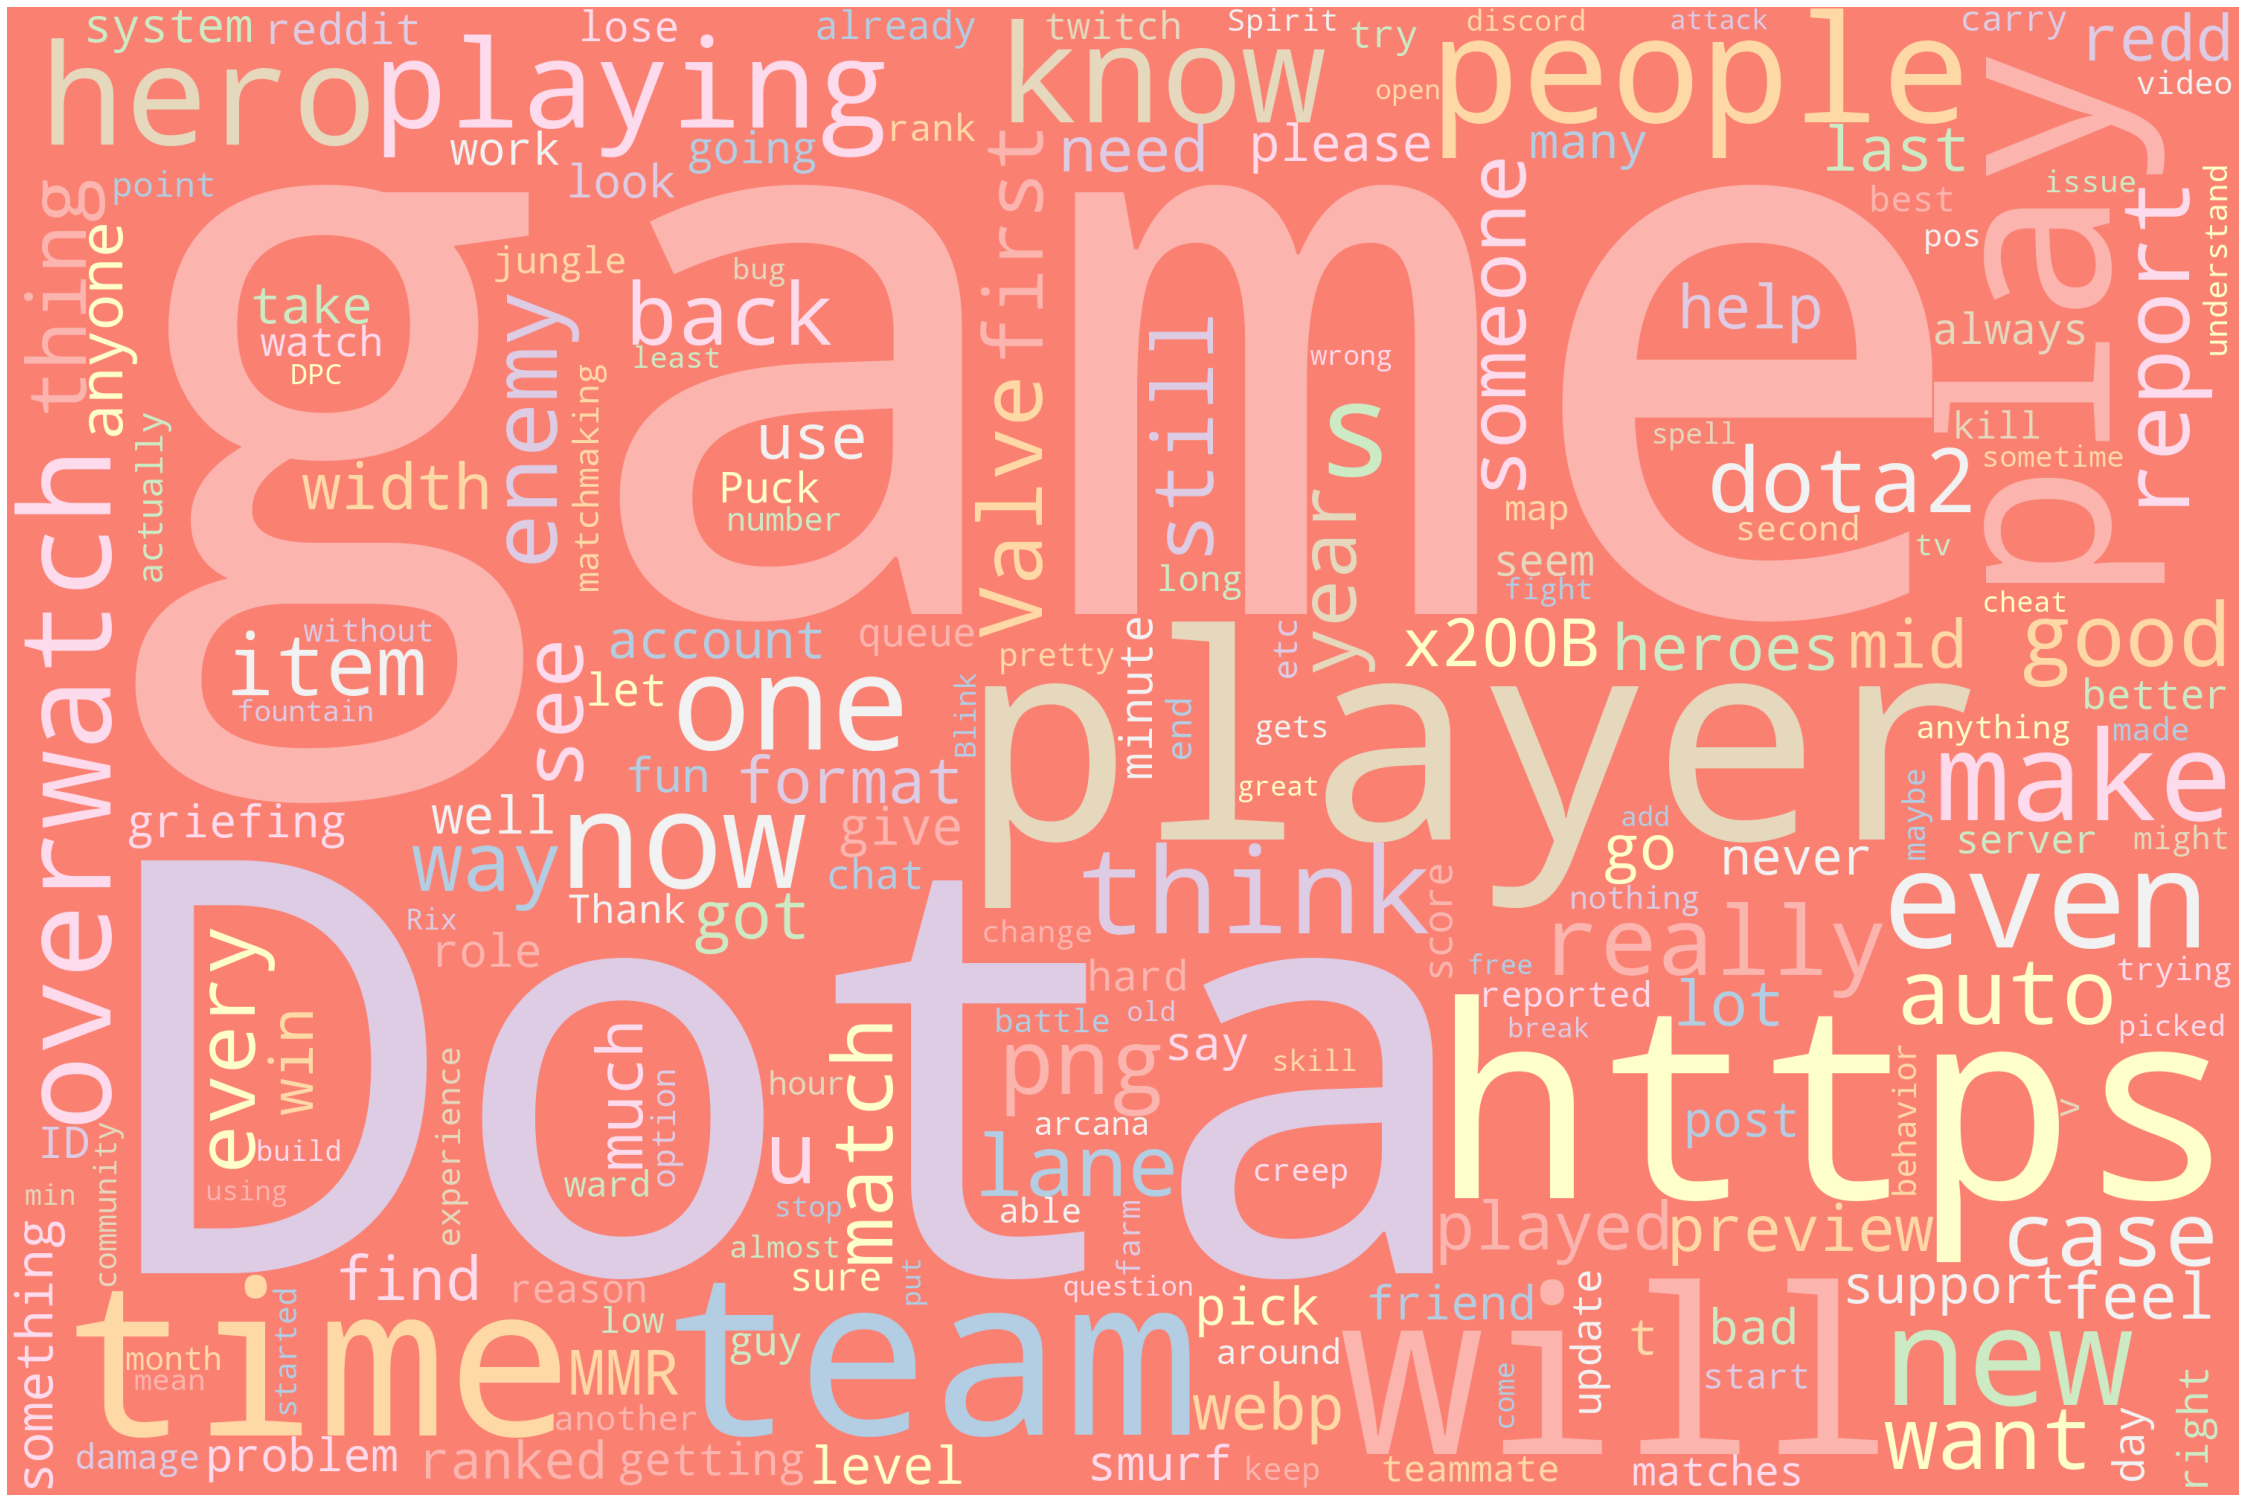

In [25]:
#Input parameter and string
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(string_dota2)

#Call plot_cloud function which we done it above
plot_cloud(wordcloud)

League of Legend
- Input single string from above and call plot_cloud function

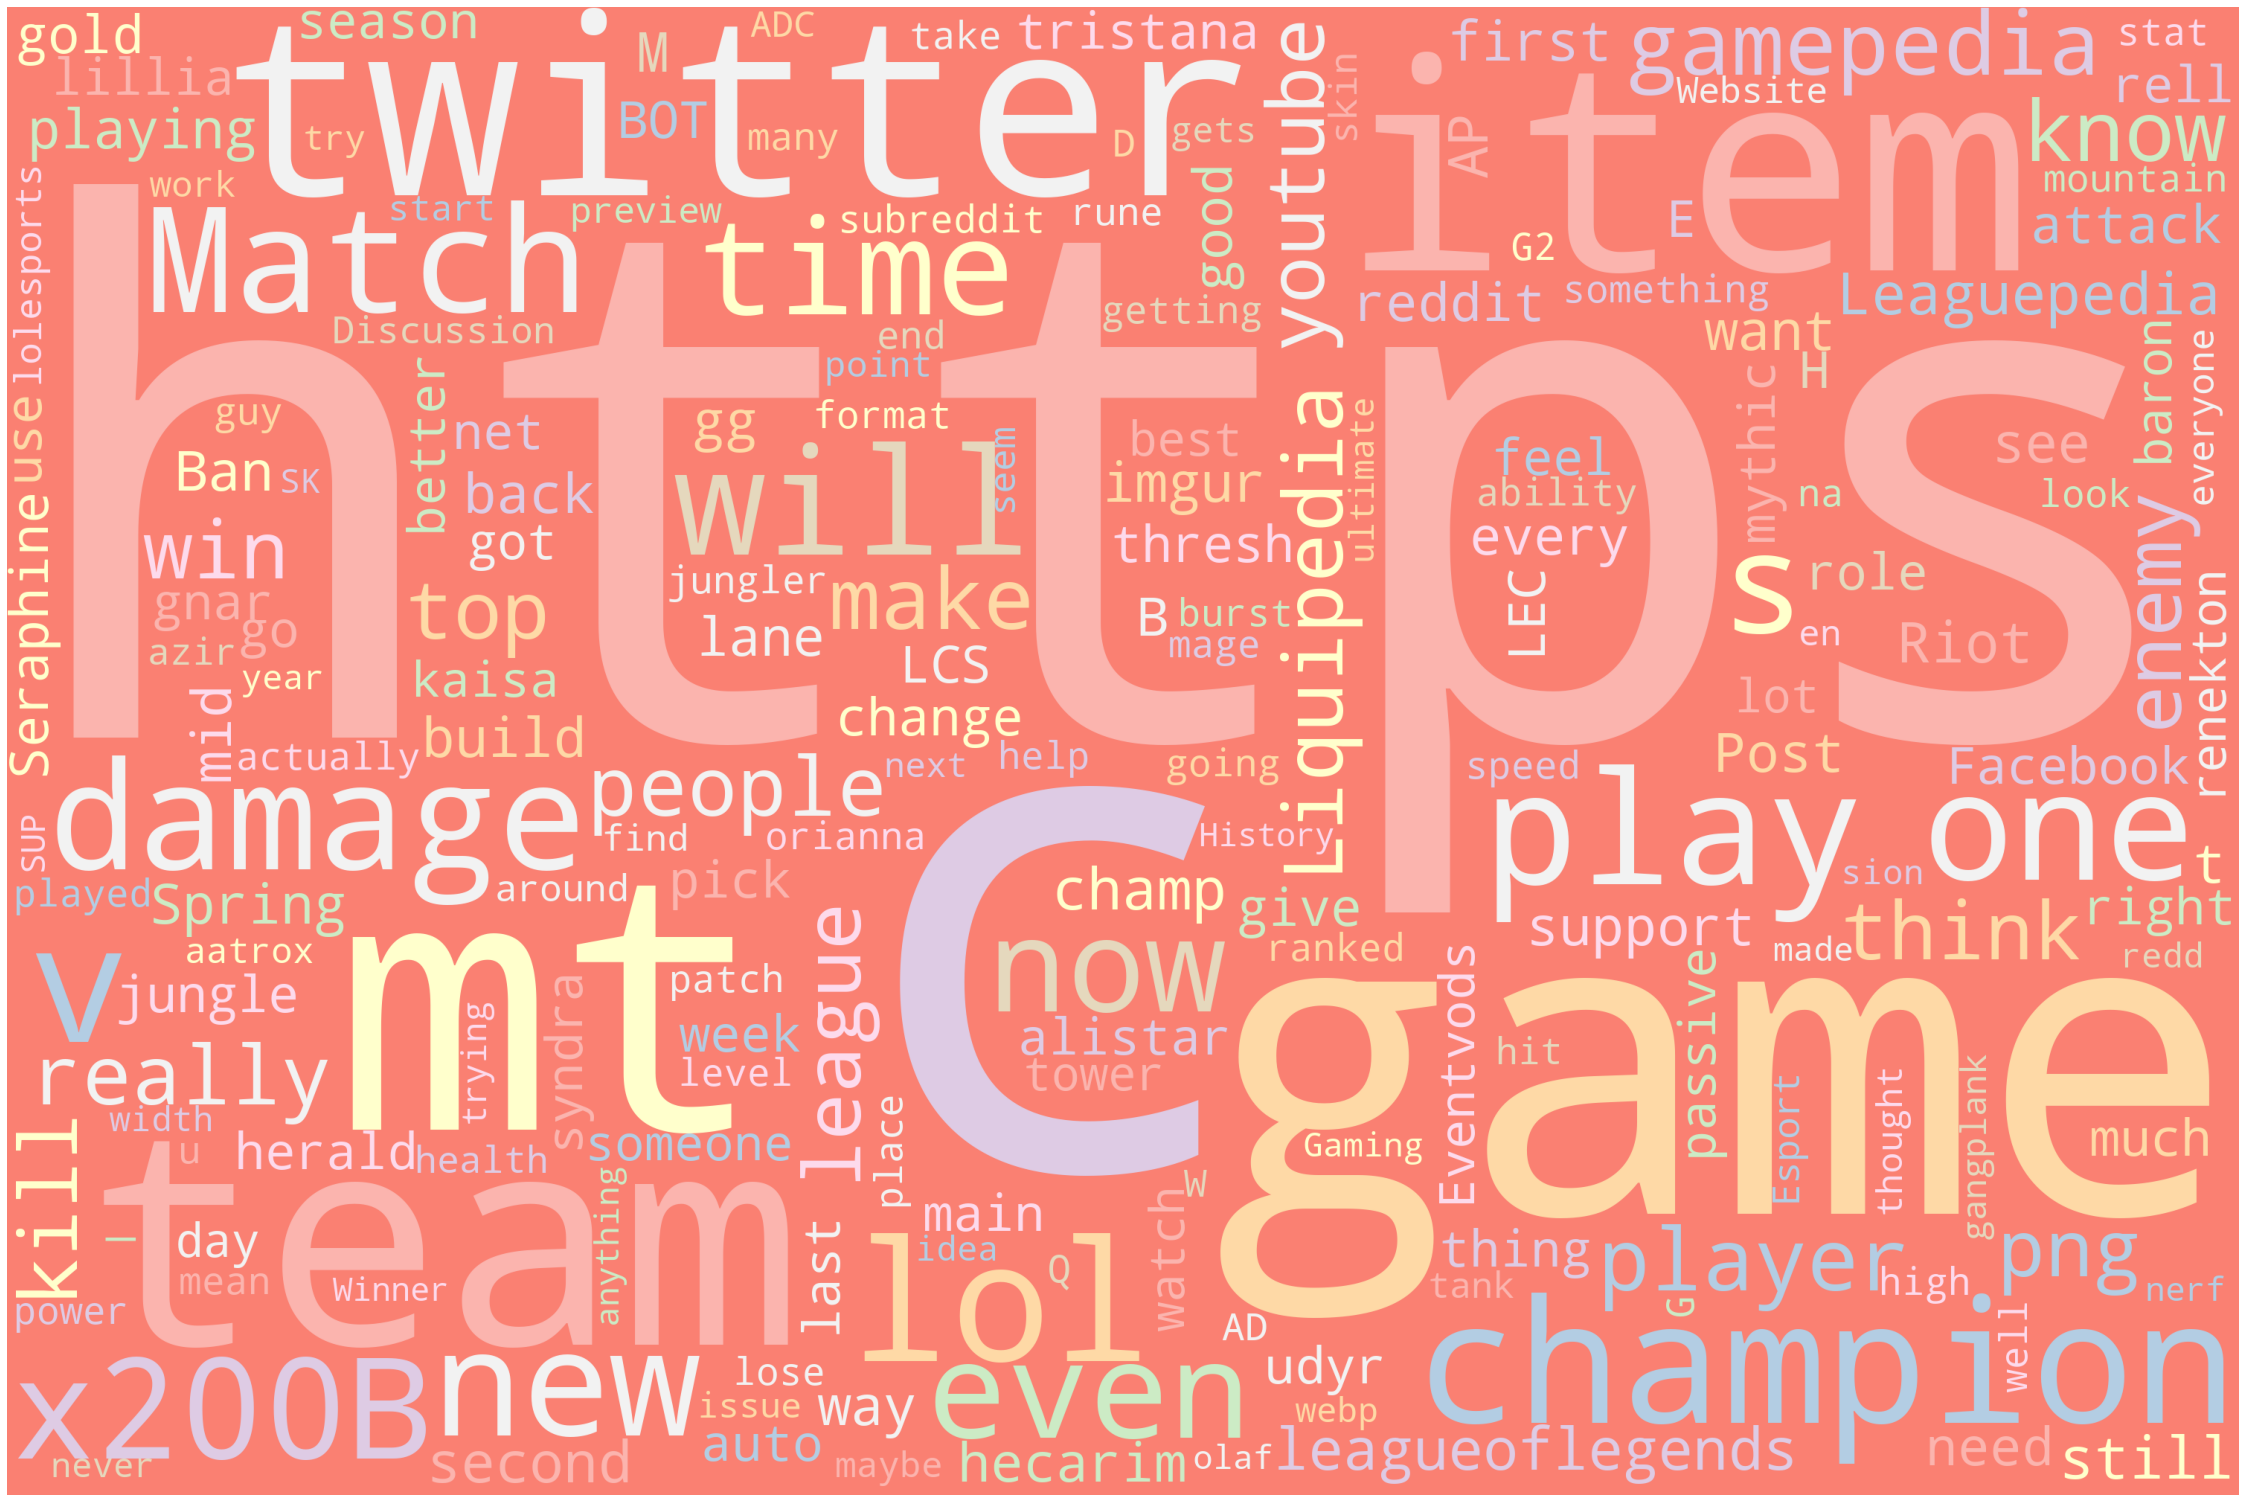

In [26]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(string_league)
# Plot
plot_cloud(wordcloud)

As you can see from wordcloud 
- Some special character is in
- There is lot's of https due to post of game (moba) look likes to talk about the gameplay a lot, therefore, in post they just post hyperlink (youtube, twitch and etc.)

**Need to do preprocessing to text before train model**

--------

# Pre-processing

**Many variety of word form and not necessary wording we need to remove and do some cleaning**

Create a function review_to_words to clean the data which is take a string want to clean and return string which is clean
This function will do a following step
1. Conver all text to lower case
2. Remove hyper link (Detect from start of word which start with http)
3. Remove punctuation (text will remain only character a-z and number 0-9)
4. Stem the word - stem it to root of it (I have try lemmatiser too their is only a slighly different on accuracy, So, I choose stemmertise)
5. Remove stop word - stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and” we remove it so it will not effect our model
6. Remove League of legend and DotA2 - Remove word that exactly the relate with subreddit will not bias on model

In [27]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Convert all text to lowercase,
    lower = raw_review.lower()
    
    # 2. Remove Https
    no_http = re.sub(r'http\S+', '', lower)
    
    # 3. Remove punctuation,
    letters_only = re.sub("[^a-zA-Z0-9]", " ", no_http).split()
    
    # 4. stem each word of the text,
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(w) for w in letters_only]
    
    # 4.2 lemmertiser each word of the text,
    #lemmatizer = WordNetLemmatizer()
    #stemmed_words = [lemmatizer.lemmatize(w) for w in letters_only]
    
    # 5. remove stopwords
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in stemmed_words if w not in stops]
    
    # 6. remove word dota2 and league
    sentence = " ".join(meaningful_words)
    remove_list = ['league', 'of', 'legend','dota2','lol','dota']
    word_list = sentence.split()
    return_string = ' '.join([i for i in word_list if i not in remove_list])
    

    return(return_string)

Iterate call function to preprocessing the text before we go into the model

In [28]:
#Preprocessing our dataset
df_dota2['all_text'] = [review_to_words(x) for x in df_dota2['all_text']]
df_league['all_text'] = [review_to_words(x) for x in df_league['all_text']]

In [29]:
df_dota2['all_text']

0      dpc season 1 march 14 match discuss pro circui...
1                               hidden statu effect abil
2                         queen pain arcana cosplay self
3                        craziest play ever part 5k hour
4                             2 anim final battl spoiler
                             ...                        
922    noob question usual pick core hero somebodi el...
923    turbo sure happi hard think smurf sad smurf co...
924                                            look tank
925    pleas help get unban 20 year ban 3 year pass w...
926    search criteria use turbo mode matchmak routin...
Name: all_text, Length: 927, dtype: object

In [30]:
df_league['all_text']

0      lec 2021 spring week 8 day 2 live discuss lec ...
1      lc 2021 spring week 6 day 2 live discuss lc sp...
2      zigg practic obsolet onli 0 8 pick rate make m...
3      doublelift doe hi best wolf impress tactic jensen
4      counter logic game vs golden guardian lc 2021 ...
                             ...                        
709    ap assassin mythic give hp half bruiser mythic...
710                                                think
711                                      agre hi opinion
712    whi yasuo q cooldown bug still game like year ...
713    long valentin skin avail tri search find anyth...
Name: all_text, Length: 714, dtype: object

Plot word cloud again to see is it better to see the word frequently use

In [31]:
string_dota2 = ''
string_dota2 = [text for text in df_dota2['all_text']]#[string_dota2 +" "+ text for text in df_dota2['all_text']]
string_dota2 = ' '.join([str(elem) for elem in string_dota2]) 

#[print(elem) for elem in string_dota2]
string_league = ''
string_league = [text for text in df_league['all_text']]#[string_dota2 +" "+ text for text in df_dota2['all_text']]
string_league = ' '.join([str(elem) for elem in string_league]) 

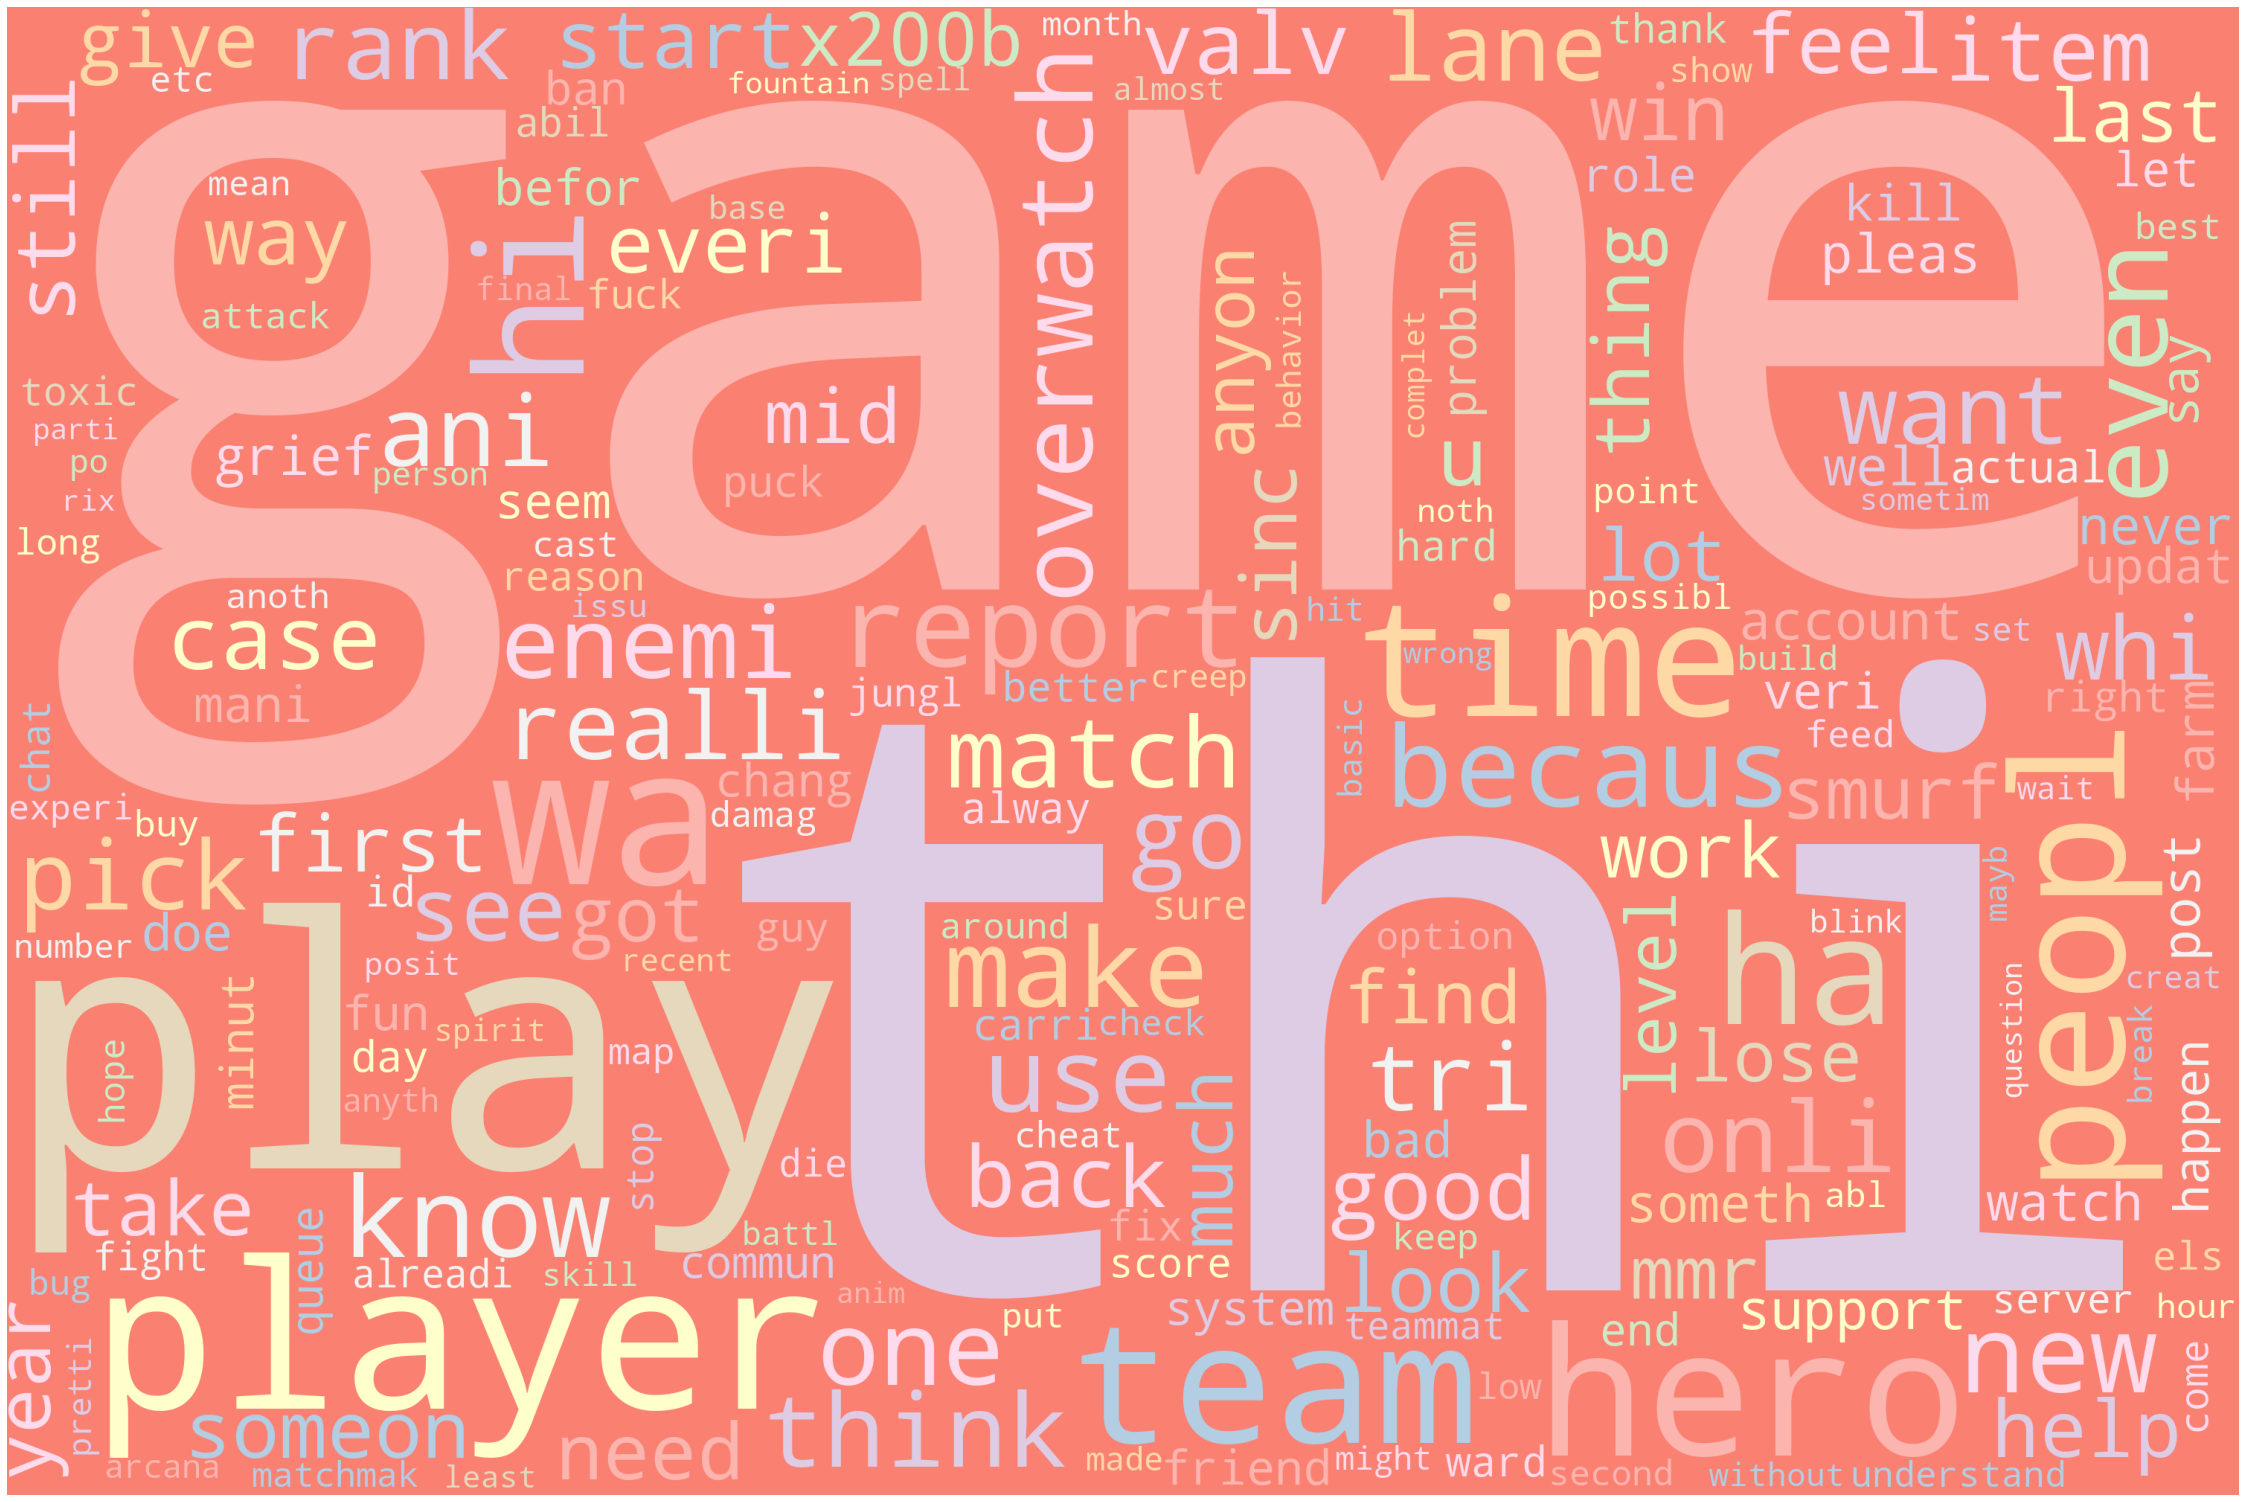

In [32]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(string_dota2)
# Plot
plot_cloud(wordcloud)

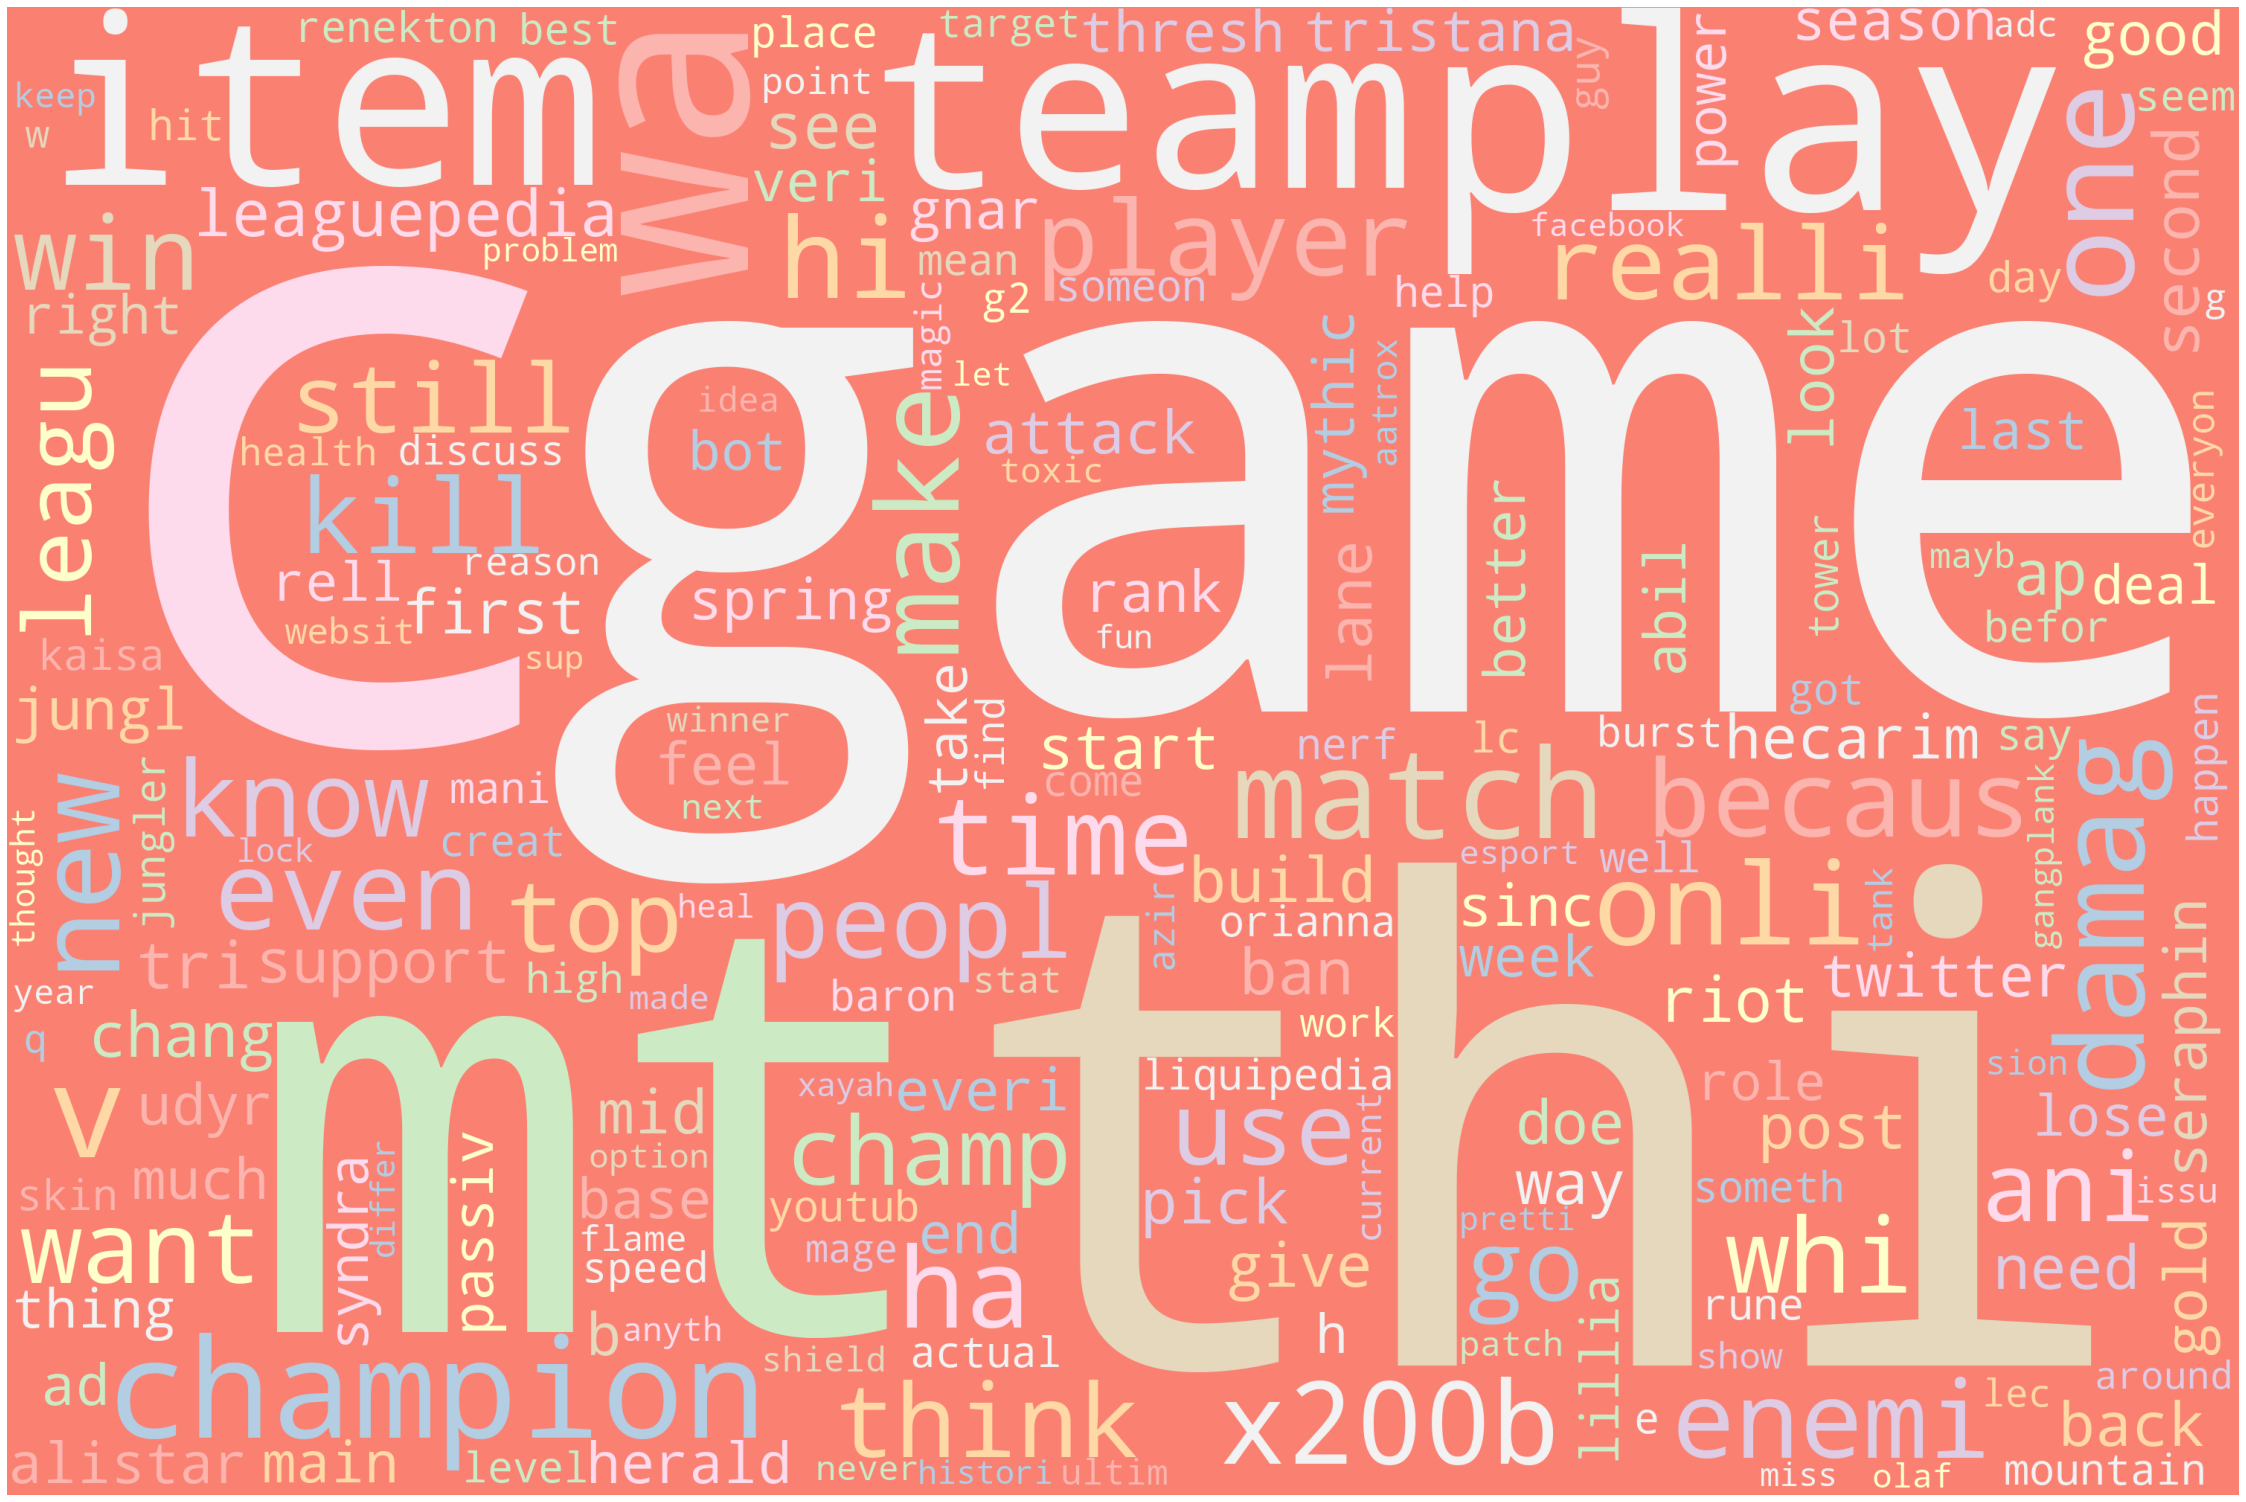

In [33]:
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(string_league)
# Plot
plot_cloud(wordcloud)

In [34]:
print("Dota2 shape:",df_dota2.shape)
print("League shape:",df_league.shape)
print("Total post from reddit = ",df_dota2.shape[0]+df_league.shape[0])

Dota2 shape: (927, 5)
League shape: (714, 5)
Total post from reddit =  1641


# Combine 2 data to a single one before take it to fit model
Concatenate both DotA2 and League of Legends (LoL) to a single dataframe call df_final

In [35]:
frames = [df_dota2, df_league]
df_final = pd.concat(frames)

#number of row equal to total post from reddit
df_final.shape

(1641, 5)

In [36]:
#check head data of dota2
df_final.head()

name                                              title  \
0  t3_m4oph4          DPC Season 1 - March 14 Match Discussions   
1  t3_m4gq47            Hidden status effects of some abilities   
2  t3_m43opa            My Queen of Pain Arcana cosplay! [self]   
3  t3_m4p3y2  Craziest Play I've Ever Been A Part of in 5k H...   
4  t3_m4f3pt                 Dota 2 anime final battle spoilers   

                                                text subreddit  \
0  ### Dota Pro Circuit 2021: Season 1 - China\n\...     DotA2   
1                                                        DotA2   
2                                                        DotA2   
3                                                        DotA2   
4                                                        DotA2   

                                            all_text  
0  dpc season 1 march 14 match discuss pro circui...  
1                           hidden statu effect abil  
2                     queen pain arcana cosplay self  
3                    craziest play ever part 5k hour  
4                         2 anim final battl spoiler

In [37]:
#check tail data of LoL
df_final.tail()

name                                              title  \
709  t3_m1x4qh  AP Assassin mythics give more HP than half the...   
710  t3_m37p3t                                 What do you think?   
711  t3_m37mns                     Do you agree with his opinion?   
712  t3_m37kub     Why is Yasuo Q cooldown bug still in the game?   
713  t3_m2tljx   How Long Are the Valentines Skins Available For?   

                                                  text        subreddit  \
709  I can understand a bit more why goredrinker an...  leagueoflegends   
710                                                     leagueoflegends   
711                                                     leagueoflegends   
712  It's been like a year or more... why isn't it ...  leagueoflegends   
713  I have tried searching but I can't find anythi...  leagueoflegends   

                                              all_text  
709  ap assassin mythic give hp half bruiser mythic...  
710                                              think  
711                                    agre hi opinion  
712  whi yasuo q cooldown bug still game like year ...  
713  long valentin skin avail tri search find anyth...

### Mapping subreddit (which is our target variable) to number 
- DotA2 to 1
- leagueoflegends to 0

In [38]:
df_final['subreddit'] = df_final['subreddit'].map({'leagueoflegends': 0, 'DotA2': 1})
df_final.head()

name                                              title  \
0  t3_m4oph4          DPC Season 1 - March 14 Match Discussions   
1  t3_m4gq47            Hidden status effects of some abilities   
2  t3_m43opa            My Queen of Pain Arcana cosplay! [self]   
3  t3_m4p3y2  Craziest Play I've Ever Been A Part of in 5k H...   
4  t3_m4f3pt                 Dota 2 anime final battle spoilers   

                                                text  subreddit  \
0  ### Dota Pro Circuit 2021: Season 1 - China\n\...          1   
1                                                             1   
2                                                             1   
3                                                             1   
4                                                             1   

                                            all_text  
0  dpc season 1 march 14 match discuss pro circui...  
1                           hidden statu effect abil  
2                     queen pain arcana cosplay self  
3                    craziest play ever part 5k hour  
4                         2 anim final battl spoiler

--------

# Model and evaluation of the model

In [39]:
X = df_final['all_text']
y = df_final['subreddit']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Baseline model 
- Majority of post is DotA2 and also score of baseline is 56.49%

In [41]:
y.value_counts(normalize=True)

1    0.564899
0    0.435101
Name: subreddit, dtype: float64

-----

### Logistic Regression (CountVectorizer)

In [42]:
cvec = CountVectorizer()
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_train_df = pd.DataFrame(X_train_cvec.toarray(),
                          columns=cvec.get_feature_names())
X_train_df

00  000  002  01  02  03  04  05  052  061  ...  zix  zoe  zombi  zone  \
0      0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
1      0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
2      0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
3      0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
4      0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
...   ..  ...  ...  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...    ...   ...   
1094   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
1095   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
1096   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
1097   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
1098   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   

      zoo  zoom  zue  zven  zwischen  zyra  
0       0     0    0     0         0     0  
1       0     0    0     0         0     0  
2       1     0    0     0         0     0  
3       0     0    0     0         0     0  
4       0     0    0     0         0     0  
...   ...   ...  ...   ...       ...   ...  
1094    0     0    0     0         0     0  
1095    0     0    0     0         0     0  
1096    0     0    0     0         0     0  
1097    0     0    0     0         0     0  
1098    0     0    0     0         0     0  

[1099 rows x 6340 columns]

Check the number word

In [43]:
len(cvec.get_feature_names())

6340

In [44]:
# Transform test
X_test_cvec = cvec.transform(X_test)
X_test_df = pd.DataFrame(X_test_cvec.toarray(),
                         columns=cvec.get_feature_names())
X_test_df.head()

00  000  002  01  02  03  04  05  052  061  ...  zix  zoe  zombi  zone  \
0   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
1   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
2   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
3   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   
4   0    0    0   0   0   0   0   0    0    0  ...    0    0      0     0   

   zoo  zoom  zue  zven  zwischen  zyra  
0    0     0    0     0         0     0  
1    0     0    0     0         0     0  
2    0     0    0     0         0     0  
3    0     0    0     0         0     0  
4    0     0    0     0         0     0  

[5 rows x 6340 columns]

In [45]:
#Training the model
lr = LogisticRegression()
lr.fit(X_train_cvec,y_train)

#Evaluating on training and testing set
print(f"Accuracy on the training set = {lr.score(X_train_cvec,y_train)}")
print(f"Accuracy on the test set = {lr.score(X_test_cvec,y_test)}")

Accuracy on the training set = 0.991810737033667
Accuracy on the test set = 0.8671586715867159


The model quite overfit, so I will use hyper parameter to decrease by using pipeline

-------

### Logistic Regression (CountVectorizer) Using Pipeline 

I try to using pipeline to find best parameter
1. CountVectorizer (transformer)
2. LogisticRegression (estimator)

Hyper parameter 
- Search over the following values of hyperparameters:
- Maximum number of features fit: 1000, 3000, 4000, 5000
- Minimum number of documents needed to include token: 2, 3
- Maximum number of documents needed to include token: 90%, 95%
- Check (individual tokens) and also check (individual tokens and 2-grams).

In [46]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'cvec__max_features': np.arange(1000,5000,1000),
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1),(1,2)]
}

grid = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': array([1000, 2000, 3000, 4000]),
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [47]:
#Best model
grid.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=3000, min_df=2)),
                ('lr', LogisticRegression())])

In [48]:
grid_model = grid.best_estimator_
grid_model.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_model.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_model.score(X_test,y_test)}")

Accuracy on the training set = 0.9854413102820746
Accuracy on the test set = 0.8616236162361623


The model still overfitting, however the accuracy of the model is quite high as 87%

In [49]:
predictions = grid_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 178
False Positives: 58
False Negatives: 17
True Positives: 289


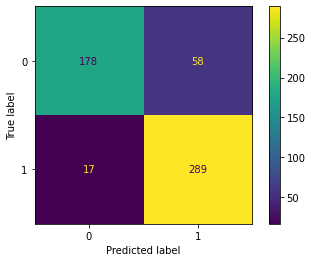

In [50]:
plot_confusion_matrix(grid_model,X_test,y_test)

After use GridSearchCV best hyperparameter for logistic regression is 
- Maximum number of features fit: 3000
- Minimum number of documents needed to include token: 2
- Maximum number of documents needed to include token: 90%

**However, this logistic regression still overfit as the training accuracy quite high<br>**
Accuracy on the training set = 0.9854413102820746<br>
Accuracy on the test set = 0.8616236162361623

------------

### Naive bayes

In [144]:
X = df_final[['all_text']]
y = df_final['subreddit']

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [146]:
cvec = CountVectorizer()

In [147]:
X_train_cvec = cvec.fit_transform(X_train['all_text'])
X_test_cvec = cvec.transform(X_test['all_text'])

In [148]:
nb = MultinomialNB()

model = nb.fit(X_train_cvec,y_train)

In [149]:
nb.score(X_train_cvec,y_train)

0.9390354868061874

In [150]:
nb.score(X_test_cvec,y_test)

0.8763837638376384

The score increase for a little bit on the test data set, However it is less overfit as you can see from  score on train dataset 

In [58]:
len(cvec.get_feature_names())

6340

In [59]:
nb.coef_ #coef

array([[ -6.58725053,  -9.72274475,  -9.02959757, ..., -10.41589193,
         -9.72274475, -10.41589193]])

In [60]:
#cvec.get_feature_names()
#nb.coef_ #coef
list_coef = pd.DataFrame((nb.coef_).T,cvec.get_feature_names())
list_coef.sort_values(0,ascending = False)

0
game     -4.039165
thi      -4.193316
play     -4.632067
player   -4.939428
get      -4.960571
...            ...
keria   -10.415892
keyston -10.415892
kha     -10.415892
khan    -10.415892
zyra    -10.415892

[6340 rows x 1 columns]

In [61]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [62]:
show_most_informative_features(cvec,nb)

	-10.4159	02             		-4.0392	game           
	-10.4159	04             		-4.1933	thi            
	-10.4159	05             		-4.6321	play           
	-10.4159	061            		-4.9394	player         
	-10.4159	09             		-4.9606	get            
	-10.4159	0g             		-5.0087	wa             
	-10.4159	0k             		-5.0784	like           
	-10.4159	0lp            		-5.1955	hero           
	-10.4159	1000g          		-5.3789	team           
	-10.4159	100c           		-5.4187	time           
	-10.4159	100g           		-5.4959	ha             
	-10.4159	100t           		-5.5032	hi             
	-10.4159	10ad           		-5.5561	becaus         
	-10.4159	10ah           		-5.5796	make           
	-10.4159	10ap           		-5.5796	even           
	-10.4159	110            		-5.6037	peopl          
	-10.4159	1200g          		-5.6284	use            
	-10.4159	1250hp         		-5.6284	new            
	-10.4159	12lifest       		-5.6885	enemi          
	-10.4159	130            		-5.7

**Quite interesting** 
- On the left hand is the word/feature which most effect for classify about LoL game
    - They talk lots about the number in game like stats (lifest - lifesteal) / gold which use to buy item in game / number of AD and AP (role like carry and mage)
- On right hand is the word/feature which most effect for classify about DotA2 game
    - Most of them is a general word which occur in MOBA game
    - Some of unique word to classify such as 
        - Hero (in LoL call it as a champion)
        - Match (in LoL more frequently use a game and etc.)

-----

**Predictions Result & Confusion metric**

In [63]:
predictions = nb.predict(X_test_cvec)

In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [65]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 180
False Positives: 56
False Negatives: 12
True Positives: 294


- True Negative means the label subreddit is "leagueoflegends" and model predict "leagueoflegends"
- False Positive means the label subreddit is "leagueoflegends" and model predict "DotA2"
- False Negative means the label subreddit is "DotA2" and model predict "leagueoflegends"
- True Positive means the label subreddit is "DotA2" and model predict "DotA2"

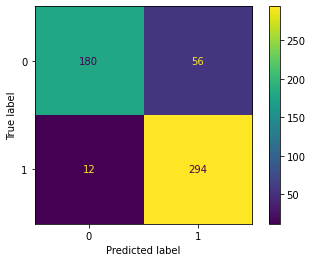

In [66]:
plot_confusion_matrix(nb,X_test_cvec,y_test)

##outcome want only LoL some of it will not detect want to detect LoL -> dota some

From my opinion I think the wrong predictions may come from the post and title which have some generical word. Therefore, I will look through the wrong prediction data

---------

### Testing pipeline

In [151]:
X = df_final['all_text']
y = df_final['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [152]:
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nb_params = {
    'cvec__max_features': np.arange(1000,5000,1000),
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.70,0.75,0.80,0.9,0.95],
    'cvec__ngram_range': [(1,1),(1,2)],
}

grid_nb_cvec = GridSearchCV(pipe_nb_cvec, param_grid=pipe_nb_params, cv=5)
grid_nb_cvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_nb_cvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_nb_cvec.score(X_test,y_test)}")

Accuracy on the training set = 0.9171974522292994
Accuracy on the test set = 0.8819188191881919


In [108]:
grid_nb_cvec.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.7, max_features=3000, min_df=2)),
                ('nb', MultinomialNB())])

In [109]:
grid_model = grid_nb_cvec.best_estimator_
grid_model.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_model.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_model.score(X_test,y_test)}")

Accuracy on the training set = 0.9171974522292994
Accuracy on the test set = 0.8819188191881919


In [156]:
grid_model.named_steps['nb'].coef_

array([[ -6.27185105,  -9.40734527,  -9.00188016, ..., -10.10049245,
         -8.30873298, -10.10049245]])

------

### ROC AOC

In [67]:
#sheet 4.04

In [68]:
pred_proba = [i[1] for i in nb.predict_proba(X_test_cvec)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

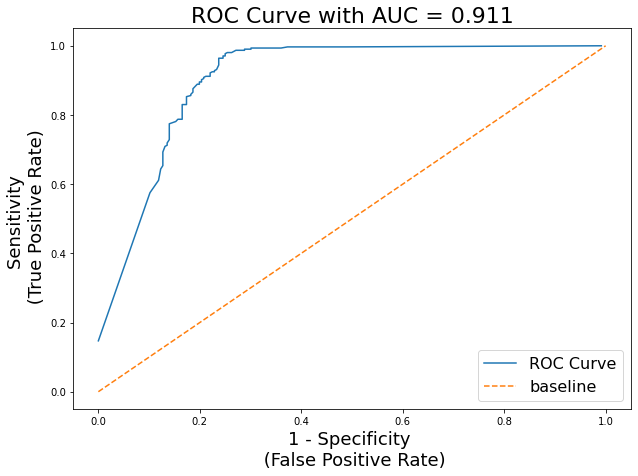

In [69]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize=18)
plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [102]:
from sklearn.metrics import plot_roc_curve

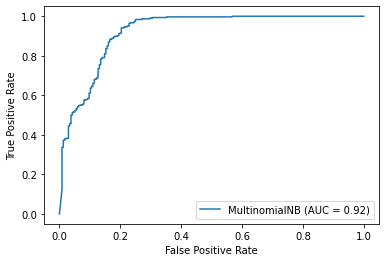

In [107]:
plot_roc_curve(nb,X_test_cvec,y_test)

In [ ]:
#AUC 92% 
#Baseline 50%

------

### Find general word and remove it
from the wrong prediction I will count the word that occur in those post and remove it and try on model again

- convert predictions data to dataframe

In [70]:
df_predictions = pd.DataFrame(predictions)
df_predictions.shape

(542, 1)

- create temp dataframe to join with the prediction above

In [71]:
temp_df = pd.concat([X_test, y_test],axis=1)
temp_df.shape

(542, 2)

- set the index of temp to be the same with temp_df so they can concatenate

In [72]:
df_predictions.set_index(temp_df.index,inplace=True)

Concate dataframe together

In [73]:
temp_df_2 = pd.concat([temp_df, df_predictions],axis=1)
temp_df_2

all_text  subreddit  0
542  report categori call tri play po 1 po 3 thi re...          1  1
633  leagu toxic game play onlin know leagu toxic g...          0  1
404  2 delay cast hello befor start shift queue shi...          1  1
198                                 tyler1 jungl chang          0  0
498  hecarim e bug play decent amount hecarim watch...          0  0
..                                                 ...        ... ..
318               infinit late game pick win late game          1  1
230  gameplay report substanti overwatch anymor see...          1  1
320                                           dk chill          1  1
620  translat lck rulebook written titl doe english...          0  0
400  discuss regard last azir nerf hi angri azir ma...          0  0

[542 rows x 3 columns]

In [74]:
#set the column name to be predict 
## subreddit is the true label
## predict is value which model predict
temp_df_2 = temp_df_2.rename(columns={0: 'predict'})
temp_df_2.head()

all_text  subreddit  predict
542  report categori call tri play po 1 po 3 thi re...          1        1
633  leagu toxic game play onlin know leagu toxic g...          0        1
404  2 delay cast hello befor start shift queue shi...          1        1
198                                 tyler1 jungl chang          0        0
498  hecarim e bug play decent amount hecarim watch...          0        0

After that I compare which data is model predict wrong
- Append the wrong prediction all_text into list_wrong
- Count false negative & false positive to make sure it is get the correct number

In [75]:
fp_count = 0
fn_count = 0
list_wrong = []
for index, row in temp_df_2.iterrows():
    if (row['subreddit'] == 1) & (row['predict'] == 0):
        fn_count += 1
        list_wrong.append(row['all_text'])
        #print(index)
    if (row['subreddit'] == 0) & (row['predict'] == 1):
        fp_count += 1
        list_wrong.append(row['all_text'])
        #print(index)
print('Fp',fp_count,'Fn',fn_count)
list_wrong[:2]

Fp 56 Fn 12


['leagu toxic game play onlin know leagu toxic game know thi never go chang someon much experi onlin game leagu wa wonder leagu consid toxic onlin game doe game take crown view poll',
 'odd dmg number ok ran strangest thing ever dure entir game feel deal enough damag went spectat mode look number someon explain whi aa 56 dmg vi 1 armour 36 26 ad reduct aa quinn onli 34 dmg onli 34 armour 25 ad reduc wa think rune noon run anyth would reduc damag anyth would damag quinn becaus wa run cut reason quinn hp vi thi wa bother game becaus watch everi encount happend 3 time cheat thi find thi kind big deal imag prove thi']

**Next, I convert list of text into dataframe**

In [76]:
temptemp = pd.DataFrame(list_wrong)
temptemp = temptemp.rename(columns = {0:'text'})
temptemp

text
0   leagu toxic game play onlin know leagu toxic g...
1   odd dmg number ok ran strangest thing ever dur...
2   play 4 year think improv play leagu around sea...
3             pro caster comment toxic chat log satir
4   would feel leagu ad behaviour rank player lot ...
..                                                ...
63  hot streak 5 pentakil row memor leagu achiev h...
64  get 10 20 fix mmr titl realli hardstuck gold i...
65                          yup bot surprisingli spot
66  tsm myth take leagu board issu tsm myth made s...
67  mmr help hey guy euw player recent got back co...

[68 rows x 1 columns]

Do countvectorizer() to count the word

In [78]:
list_coef

0
00        -6.587251
000       -9.722745
002       -9.029598
01        -9.317280
02       -10.415892
...             ...
zoom      -9.722745
zue       -9.722745
zven     -10.415892
zwischen  -9.722745
zyra     -10.415892

[6340 rows x 1 columns]

Put top 20 word that most found in wrong prediction post into remove list

In [79]:
word_wrong_most = list(word_cvec_wrong_counts_pf.index)
remove_list = word_wrong_most[:20]
remove_list

['game',
 'thi',
 'play',
 'get',
 'like',
 'wa',
 'player',
 'would',
 'rank',
 'time',
 'team',
 'leagu',
 'toxic',
 'peopl',
 'know',
 'think',
 'hi',
 'realli',
 'back',
 'chat']

Create function remove word from the word list

In [80]:
def remove_word(string,remove_list):
    #sentence = " ".join(meaningful_words)
    word_list = string.split()
    #print(word_list)
    #print("remove list",remove_list)
    return_string = ' '.join([i for i in word_list if i not in remove_list])
    
    return return_string

Duplicate dataframe to make sure it will not effect the raw data

In [81]:
improve_df_dota2 = df_dota2
improve_df_league = df_league
improve_df_final = df_final

In [82]:
#Check it got the same data
print(improve_df_final.shape)
print(df_final.shape)

(1641, 5)
(1641, 5)


Call the function with remove word

In [83]:
improve_df_dota2['all_text'] = [remove_word(x,remove_list) for x in improve_df_dota2['all_text']]
improve_df_league['all_text'] = [remove_word(x,remove_list) for x in improve_df_league['all_text']]
improve_df_final['all_text'] = [remove_word(x,remove_list) for x in improve_df_final['all_text']]

Re-do the model once again with removing general word

In [84]:
X = df_final[['all_text']]
y = df_final['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)
cvec = CountVectorizer()
X_train_cvec = cvec.fit_transform(X_train['all_text'])
X_test_cvec = cvec.transform(X_test['all_text'])

nb = MultinomialNB()
model = nb.fit(X_train_cvec,y_train)

In [85]:
nb.score(X_train_cvec,y_train)
#0.9372156505914467

0.9390354868061874

In [86]:
nb.score(X_test_cvec,y_test)
#0.8745387453874539

0.8763837638376384

In [87]:
predictions = nb.predict(X_test_cvec)

In [88]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 185
False Positives: 51
False Negatives: 16
True Positives: 290


**Naive bayes before remove general word**
- False positive: 56
- False negative: 12

**Naive bayes after remove general word**
- False Positives: 51
- False Negatives: 16

Remove general word from text improve the score slightly,not quite effect model that much

In [89]:
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))
print('Recall / Sensivity: {}'.format(round(tp/(tp+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))

Accuracy: 0.8764
Misclassification rate: 0.1236
Precision: 0.8504
Recall / Sensivity: 0.9477
Specificity: 0.7839


- Accuracy: Percentage of observation which model predict correctly is 87.64%
- Sensivity: Among those post interpret as DotA2, how many predict I correct as DotA2 94.77% of the post
- Specificity: Among those post interpret as League of Legends, how many predict did model predicting league of legends 78.39%

-----

### NB & TF-IDF model

In [90]:
X = improve_df_final[['all_text']]
y = improve_df_final['subreddit']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [92]:
tvec = TfidfVectorizer()
df = pd.DataFrame(tvec.fit_transform(X_train['all_text']).toarray(),
                  columns=tvec.get_feature_names())
df.head()

00  000  002   01   02   03   04   05  052  061  ...  zix  zoe  zombi  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0    0.0   

   zone       zoo  zoom  zue  zven  zwischen  zyra  
0   0.0  0.000000   0.0  0.0   0.0       0.0   0.0  
1   0.0  0.000000   0.0  0.0   0.0       0.0   0.0  
2   0.0  0.100681   0.0  0.0   0.0       0.0   0.0  
3   0.0  0.000000   0.0  0.0   0.0       0.0   0.0  
4   0.0  0.000000   0.0  0.0   0.0       0.0   0.0  

[5 rows x 6320 columns]

In [93]:
X_train_tvec = tvec.fit_transform(X_train['all_text'])
X_test_tvec = tvec.transform(X_test['all_text'])

In [110]:
nb = MultinomialNB()

# Fit logistic regression.
nb.fit(X_train_tvec, y_train)

# Evaluate logistic regression.
print(f'Training Score: {lr.score(X_train_tvec, y_train)}')
print(f'Testing Score: {lr.score(X_test_tvec, y_test)}')

Training Score: 0.978161965423112
Testing Score: 0.8579335793357934


In [113]:
X = df_final['all_text']
y = df_final['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [128]:
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_nb_tvec_params = {
    'tvec__max_df': [0.70,0.75,0.80,0.9,0.95],
    'tvec__max_features': np.arange(1000,5000,1000),
    'tvec__min_df': [2,3],
    'tvec__ngram_range': [(1,1),(1,2)],
}

grid_nb_tvec = GridSearchCV(pipe_nb_tvec, param_grid=pipe_nb_tvec_params, cv=5)
grid_nb_tvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_nb_cvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_nb_cvec.score(X_test,y_test)}")

Accuracy on the training set = 0.9171974522292994
Accuracy on the test set = 0.8819188191881919


In [125]:
pipe_nb_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

-----

# KNN 

In [ ]:
#KNeighborsClassifier

In [134]:
X = df_final['all_text']
y = df_final['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [139]:
pipe_knn_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_knn_cvec_params = {
    'cvec__max_features': np.arange(1000,5000,1000),
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.7,0.8,0.9,0.95],
    'cvec__ngram_range': [(1,1),(1,2)],
    'knn__n_neighbors': range(1, 51, 10),
    'knn__metric': ['euclidean', 'manhattan']
}

grid_knn_cvec = GridSearchCV(pipe_knn_cvec, param_grid=pipe_knn_cvec_params, cv=5)
grid_knn_cvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_knn_cvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_knn_cvec.score(X_test,y_test)}")

Accuracy on the training set = 0.9981801637852593
Accuracy on the test set = 0.6937269372693727


In [142]:
grid_knn_cvec.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.7, max_features=3000, min_df=2,
                                 ngram_range=(1, 2))),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])

In [140]:
X = df_final['all_text']
y = df_final['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [141]:
pipe_knn_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_knn_tvec_params = {
    'tvec__max_df': [0.7,0.8,0.9,0.95],
    'tvec__max_features': np.arange(1000,5000,1000),
    'tvec__min_df': [2,3],
    'tvec__ngram_range': [(1,1),(1,2)],
    'knn__n_neighbors': range(1, 1000, 200),
    'knn__metric': ['euclidean', 'manhattan']
}

grid_knn_tvec = GridSearchCV(pipe_knn_tvec, param_grid=pipe_knn_tvec_params, cv=5)
grid_knn_tvec.fit(X_train,y_train)
print(f"Accuracy on the training set = {grid_knn_tvec.score(X_train,y_train)}")
print(f"Accuracy on the test set = {grid_knn_tvec.score(X_test,y_test)}")

Accuracy on the training set = 0.732484076433121
Accuracy on the test set = 0.7232472324723247


In [143]:
grid_knn_tvec.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.7, max_features=2000, min_df=3)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=201))])

In [132]:
pipe_knn_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

--------

# Conclusion and Recommendations

The score of prediction on LinearRegression, Naive-Bayes, TF-IDF is close to each other around 87%
- I suggest the model Naive-Bayes because it is least overfitting when compare with 2 others 

|Model|Training Accuracy|Testing Accuracy|Different|
|---|---|---|----|
|Baseline|56.49%|-|-|
|LR(best model)|0.9854413102820746|0.8616236162361623|0.12378|
|Naive-Bayes|0.9372156505914467|0.8745387453874539|**0.06268**|
|TF-IDF|0.978161965423112|0.8745387453874539|0.10362|

Most coefficient word in each category

|Coef|LoL word| Coef| DotA2 word|
|---|---|---|----|
|-10.3035|	02|                 -5.0831| hero|           
|-10.3035|	04|            		-5.3835|ha       |      
|-10.3035|	05|             	-5.4437|	becaus|         
|-10.3035|	061|            	-5.4672|	make   |        
|-10.3035|	09|           		-5.4672|	even        |   
|-10.3035|	0g|             	-5.5160|	use      |      
|-10.3035|	0k|            		-5.5160|	new           | 
|-10.3035|	0lp|            	-5.5761|	enemi      |    
|-10.3035|	1000g|          	-5.5940|	report      |   
|-10.3035|	100c|           	-5.6030|	one          |  
|-10.3035|	100g|           	-5.6785|	go             |
|-10.3035|	100t|           	-5.6884|	overwatch     | 
|-10.3035|	10ad|           	-5.7185|	match          |
|-10.3035|	10ah|           	-5.7496|	ani            |
|-10.3035|	10ap|           	-5.7709|	onli           |
|-10.3035|	110|           		-5.8037|	also           |
|-10.3035|	1200g|          	-5.8262|	pick        |   
|-10.3035|	1250hp|         	-5.8376|	whi          |  
|-10.3035|	12lifest|       	-5.8376|	want          | 
|-10.3035|	130|            	-5.8376|	tri  |

On the left hand is the word/feature which most effect for classify about LoL game
- They talk lots about the number in game like stats (lifest - lifesteal) / gold which use to buy item in game / number of AD and AP (role like carry and mage)

On right hand is the word/feature which most effect for classify about DotA2 game
- Most of them is a general word which occur in MOBA game
- Some of unique word to classify such as
    - Hero (in LoL call it as a champion)
    - Match (in LoL more frequently use a game and etc.)

Scope for future improvements:
- Try ensemble models, such as random forest classifier
- Ability for model to classify more than two subreddits

By default, what does a true negative mean here?
True negatives are things we correctly predict to be negative.
In this case, since Twitter = 1, a true negative means I correctly predict something is a Facebook post.
By default, what does a false positive mean here?
False positives are things we falsely predict to be positive.
In this case, since Twitter = 1, a false positive means I incorrectly preidct something is a tweet (when it's really a Facebook post).